<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/P1_EULER_IMPLICIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Volem trobar els valors de les temperatures de la següent forma:

$\vec{T_i}=M^{-1}(\vec{T_{i-1}}+\vec{\Delta t})$


T_0= 674.2857142857143
amb un dt= 0.0001 , calen 252 iteracions per arribar al temps normalitzat 0.025099999999999904
amb un dt= 5e-05 , calen 501 iteracions per arribar al temps normalitzat 0.025000000000000203


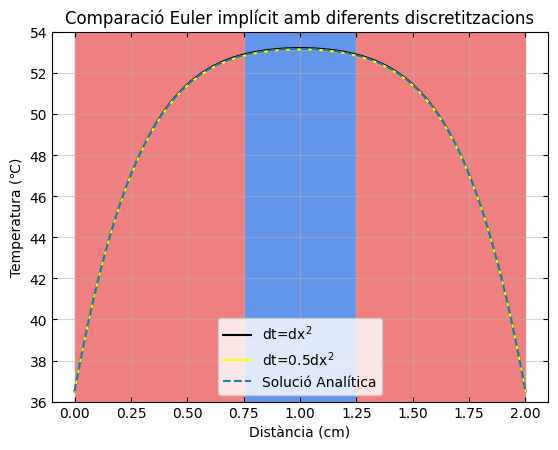

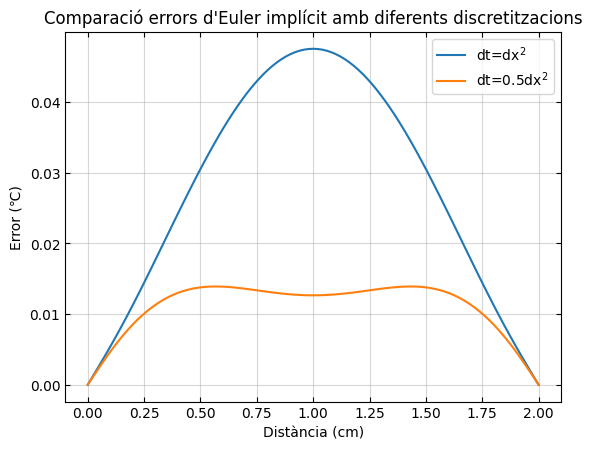

In [21]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import matplotlib.patches as pt

# CÀLCULS PREVIS
# Recordem que les nostres dades són
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40
# Amb aquests, calculem la difusivitat, que farem servir per a la normalització
alpha= kappa/(C_v*rho)
# Imposem la nostra normalització
N= 101
x_0= 0.02 # Triat per tal de normalitzar x_f, que ha de ser 0.02 m (2 cm)
x_f= 0.02/x_0
t_0= x_0**2/alpha # \tilde{t}=t/t_0
t_f= 0.025 # Ja està normalitzat, ho diu l'enunciat
P_ext= volts**2*sigma/(2*(x_0)**2) # Calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 # Unitats=Kelvin
print("T_0=", T_0)
T_init= 309.65/T_0 # Hem passat la temperatura inicial 36.5℃ a kelvin i després l'hem normalitzat

# Definim els dos casos de variacions de les variables
dx= x_f/(N-1) # Com tenim N punts, tenim N-1 intervals
dt_1= dx**2
dt_2= 0.5*dx**2

# Per tal d'aplicar el mètode d'Euler Implícit, caldrà invertir una matriu mitjançant un procediment numèric (Jacobi, en el nostre cas)
def jacobi(A, B, tol=1e-8):
    n = len(B)
    x = np.zeros(n)           # Aproximació inicial
    x_nou = np.zeros(n)

    for _ in range(1000):
        for i in range(n):
            s = 0.0
            for j in range(n):    # Recorrem les columnes j
                if j != i:        # Saltem la diagonal
                    s += A[i, j] * x[j]
            x_nou[i] = (B[i] - s) / A[i, i]   # Actualitzem la component i
        if np.linalg.norm(x_nou - x, ord=np.inf) < tol:  # Comprovem que el canvi és menor a la tolerància triada
            return x_nou
        x[:] = x_nou

    return x

def invertir_matriu_jacobi(A, tol=1e-8):
    A = np.array(A, dtype=float)
    n = A.shape[0]
    I = np.eye(n)
    A_inv = np.zeros_like(A)
    for k in range(n):
        e = I[:, k]               # Vector base e_k
        A_inv[:, k] = jacobi(A, e, tol=tol)  # Columna k de la inversa
    return A_inv

# Creem una funció aplicable a qualsevol temperatura inicial (sempre que sigui la mateixa temperatura que als contorns),
def Euler_implicit (T_i, t_f, dx, dt): # Li has de passar les variables (escalars) normalizades
    T_i_vec=np.ones(N)*T_i
    i= 1
    t_i= 0
    # Creem la matriu M
    gamma= dt/(dx**2)
    col1= [0]*(N)
    fila1= [0]*(N)
    col1[0] = fila1[0] = 1 + 2*gamma
    col1[1] = fila1[1] = -gamma
    matriu = toeplitz(col1, fila1) # Crea una matriu tridiagonal amb 1-2gamma a la diagonal princial i -gamma a les diagonals de sobre i de sota

    #IMPOSEM LES CONDICIONS DE CONTORN
    matriu[0,:]  = 0 #això vol dir que tots els elements (:) de la primera fila (la fila 0, corresponent al temps inicial t=0) valen 0
    matriu[0,0]  = 1 #i després de fer que tots els elements valguin 0 fas que el primer (el de la primera fila i la primera columna
                          #és a dir, el primer de la diagonal) valgui 1, de forma que quan multipliques la matriu per T_inic et continua
                          #quedant T_inic
    matriu[-1,:] = 0 #el mateix que abans, fas que tots els elements de la última fila siguin 0 excepte el de l'última columna, és a dir,
                          #l'últim de la diagonal, el qual val 1
    matriu[-1,-1]= 1

    # Invertim la matriu amb el mètode de Jacobi
    matriu_inversa = invertir_matriu_jacobi(matriu)

    while t_i<t_f: #com la nostra equació és de la forma Ax=b, on A=inv(M) i x=\vec{T_i}, anem a trobar b=\vec{T_{i-1}+∆t}
      # I apliquem això per trobar T_i_vec
      b = T_i_vec + np.ones(N)*dt
      b[0]  = T_i
      b[-1] = T_i
      T_i_vec = np.matmul(matriu_inversa, b)
      T_i_vec[0]  = T_i
      T_i_vec[-1] = T_i
      t_i = t_i + dt
      i = i + 1
    print("amb un dt=",dt,", calen",i,"iteracions per arribar al temps normalitzat", t_i)
    return T_i_vec

# Apliquem la funció que hem creat als nostres dos casos de discretitzacions
T_i_1 = Euler_implicit(T_init, t_f, dx, dt_1)
T_i_2 = Euler_implicit(T_init, t_f, dx, dt_2)

# Temperatures reals, desfem la normalització i passem a ℃
T_real_1 = T_i_1 * T_0 - 273.15
T_real_2 = T_i_2 * T_0 - 273.15

#GRAFIQUEM
dx_llista = np.linspace(0, 2, 101) # Eix x en cm

# RECTANGLES
ys_tot = np.concatenate((T_real_1, T_real_2))
lim_inf_y = float(np.floor(np.min(ys_tot)))
altura    = float(np.floor(np.max(ys_tot) + 1) - lim_inf_y)

fig, ax = plt.subplots()

rectangle_cor = pt.Rectangle((0.75, lim_inf_y), 0.5, altura,
                             color="cornflowerblue", alpha=1)
rectangle_esq = pt.Rectangle((0.0,  lim_inf_y), 0.75, altura,
                             color="lightcoral",   alpha=1)
rectangle_dre = pt.Rectangle((1.25, lim_inf_y), 0.75, altura,
                             color="lightcoral",   alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

# corbes d'Euler implícit sobre el mateix eix
ax.plot(dx_llista, T_real_1, color="k",      label="dt=dx$^2$")
ax.plot(dx_llista, T_real_2, color="yellow", label="dt=0.5dx$^2$")
plt.ylim(lim_inf_y, np.floor(max(ys_tot)+1))
ax.set_xlabel("Distància (cm)")
ax.set_ylabel("Temperatura (℃)")
ax.tick_params(direction="in", top=True, right=True)
ax.set_title("Comparació Euler implícit amb diferents discretitzacions")
ax.legend()

T_real_analitica = [36.5, 37.66969108, 38.77435843, 39.81640155, 40.79821064, 41.72216161,
 42.59061136, 43.40589333, 44.17031304, 44.88614393, 45.55562325, 46.18094826,
 46.76427258, 47.30770281, 47.81329543, 48.28305392, 48.71892617, 49.12280218,
 49.49651205, 49.84182427, 50.16044422, 50.45401308, 50.72410691, 50.97223607,
 51.19984485, 51.40831139, 51.59894779, 51.77300053, 51.93165095, 52.07601607,
 52.20714947, 52.32604233, 52.43362469, 52.53076667, 52.61827989, 52.69691893,
 52.76738279, 52.83031642, 52.88631225, 52.93591169, 52.97960659, 53.01784069,
 53.05101097, 53.07946891, 53.10352169, 53.12343327, 53.13942529, 53.15167798,
 53.16033077, 53.16548287, 53.16719365, 53.16548287, 53.16033077, 53.15167798,
 53.13942529, 53.12343327, 53.10352169, 53.07946891, 53.05101097, 53.01784069,
 52.97960659, 52.93591169, 52.88631225, 52.83031642, 52.76738279, 52.69691893,
 52.61827989, 52.53076667, 52.43362469, 52.32604233, 52.20714947, 52.07601607,
 51.93165095, 51.77300053, 51.59894779, 51.40831139, 51.19984485, 50.97223607,
 50.72410691, 50.45401308, 50.16044422, 49.84182427, 49.49651205, 49.12280218,
 48.71892617, 48.28305392, 47.81329543, 47.30770281, 46.76427258, 46.18094826,
 45.55562325, 44.88614393, 44.17031304, 43.40589333, 42.59061136, 41.72216161,
 40.79821064, 39.81640155, 38.77435843, 37.66969108, 36.5]
 # Solució analítica en ºC prèviament calculada

plt.plot(dx_llista, T_real_analitica, "--", label="Solució Analítica")
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.plot(dx_llista, abs(T_real_1-T_real_analitica), label="dt=dx$^2$")
plt.plot(dx_llista, abs(T_real_2-T_real_analitica), label="dt=0.5dx$^2$")
plt.xlabel("Distància (cm)")
plt.ylabel("Error (℃)")
plt.title("Comparació errors d'Euler implícit amb diferents discretitzacions")
plt.grid(True, alpha=0.5)
plt.legend()
plt.tick_params(direction="in", top=True, right=True)
plt.show()
